In [1]:
from cycler import cycler
from os import listdir, stat
from os.path import isfile, join

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np


In [2]:
%matplotlib inline
# plt.ion()
# sns.set_palette('Set3')
# plt.style.use('Solarize_Light2')
# color1 = cycler('color', [
#     'c',
#     # 'k',
#     'r',
#     'g',
#     'b',
#     # 'y',
# ])
color3 = cycler('color', sorted(list(
    set(plt.rcParams['axes.prop_cycle'].by_key()['color']))))
linestyle1 = cycler('ls', ['-', '--', '-.', ':'])
# c1 = color1 * linestyle1
# c2 = linestyle1 * color1
c3 = linestyle1 * color3
# c4 =  color3 * linestyle1
plt.rc('axes', prop_cycle=c3)

hatch_patterns = ['///', '', '\\/...', '--', '\\', '', '-', '.', '+']


def filterr(df, col, val):
    return df[df[col] == val].reset_index(drop=True)


def filterrnot(df, col, val):
    return df[df[col] != val].reset_index(drop=True)


def filterrnz(df, col):
    return filterrnot(df, col, 0)


def filterrgte(df, col, min_val):
    return df[df[col] >= min_val]


def plot_line(xs, ys, label, color=None, marker=None, ax=None):
    if ax is None:
        ax = plt
    return ax.plot(xs, ys, label=label, color=color, marker=marker)


def setup_plot(title, xlabel, ylabel, ax=None, xscale='linear', xbase=10, yscale='linear', ybase=10):
    if ax is not None:
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel.title())
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        if xscale != 'linear':
            ax.set_xscale(xscale, base=xbase)
        if yscale != 'linear':
            ax.set_yscale(yscale, base=ybase)
        return

    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel.title())
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xscale != 'linear':
        plt.xscale(xscale, base=xbase)
    if yscale != 'linear':
        plt.yscale(yscale, base=ybase)


def grouped_bars(df, group_name, title, yname):
    bars_per_group = len(df.columns) - 1
    x = np.arange(len(df))
    width = 1 / (bars_per_group+1)

    offset_mult = 0
    fig, ax = plt.subplots(layout='constrained')

    for col in filter(lambda x: x != group_name, df.columns):
        offset = width * offset_mult
        rects = ax.bar(x + offset, df[col], width, label=col)
        ax.bar_label(rects, padding=3)
        offset_mult += 1

    ax.set_title(title.title())
    ax.set_ylabel(yname.title())
    ax.set_xticks(x + width, df[group_name])
    ax.legend()
    plt.show()


def graph_by(df, col1, col2, xname, yname, sharey=True, omap=None, unit='Time (s)'):
    col1_vals = sorted(list(set(df[col1])), reverse=True)
    nplots = len(col1_vals)

    yscale = 'log'
    ybase = 10
    xscale = 'log'
    xbase = 2

    fig, axs = plt.subplots(nplots, sharex=False,
                            sharey=sharey, figsize=(8, (3*nplots)+1))
    plt.subplots_adjust(hspace=.45)
    # all_ymin, all_ymax = None, None

    charIdx = 'A'
    for cnt, v1 in enumerate(col1_vals):
        ax = axs[cnt] if nplots > 1 else axs
        ax.grid()
        setup_plot(f'{charIdx}: ${col1.replace("lf", "L")}={v1}$',
                   xname.replace('vl', 'value size $|v|$'),
                   f'{yname.title()} {unit}', ax=ax,
                   xscale=xscale, xbase=xbase, yscale=yscale, ybase=ybase)
        charIdx = chr(ord(charIdx) + 1)

        dv1 = filterr(df, col1, v1)
        if omap is not None:
            plot_line(omap['id'], omap[yname], 'OMap', ax=ax, marker='+')

        col2_vals = sorted(list(set(dv1[col2])))
        for v2 in col2_vals:
            dv1v2 = filterr(dv1, col2, v2)
            d = filterrnz(dv1v2, xname)
            d = filterrnz(d, yname)
            d.sort_values([xname], ascending=True, inplace=True)
            x = d[xname]
            y = d[yname]
            plot_line(x, y, f'{col2.replace("lf", "L")}={v2}',
                      marker='', ax=ax)

        ymin, ymax = ax.get_ylim()

        if xname == 'vl' and (col1 == 's' or col2 == 's'):
            s = v1 if col1 == 's' else v2
            assert len(set(d['n'])) == 1
            n = list(set(d['n']))[0]
            l = round(np.log2(n))
            p = (l+1) // s
            levels = list(range(l - ((s-1) * p), l+1, p))
            if max(levels) > 19:
                levels.append(19)
            levels = list(filter(lambda x: x <= 19, levels))
            ax.vlines(2 ** np.asarray(levels),
                      ymin=ymin, ymax=ymax,
                      color='purple', linestyle=':', label='level')

    # plt.ylim(all_ymin, all_ymax)
    labels_handles = {
        label: handle
        for ax in (axs if nplots > 1 else [axs])
        for handle, label in zip(*(
            [x[2], x[0], x[1]] + x[3:]
            for x in ax.get_legend_handles_labels()
        ))
    }
    labels = labels_handles.keys()
    handles = labels_handles.values()

    g = fig.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.48, 0.95),
        bbox_transform=plt.gcf().transFigure,
        ncols=7,
        facecolor='whitesmoke',
        columnspacing=1.2,
    )
    # leg_lines = leg.get_lines()
    # leg_texts = leg.get_texts()
    # plt.setp(leg_lines, linewidth=6)


In [5]:
allofs = pd.read_csv('data/ofs.csv')
print(len(allofs))
allofsappend = pd.read_csv('data/ofs-append.csv')
print(len(allofsappend))
allomap = filterr(pd.read_csv('data/omap.csv'), 'n', 2**23)
print(len(allomap))

ofs_sm = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 1), 'ssd', 1)
ofs_ss = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 0), 'ssd', 1)
ofs_hm = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 1), 'ssd', 0)
ofs_hh = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 0), 'ssd', 0)
ofs_mm = filterr(
    filterr(filterr(allofs, 'data_mem', 1), 'aux_mem', 1), 'ssd', 0)

ofs = [
    ofs_sm,
    ofs_ss,
    ofs_hm,
    ofs_hh,
    ofs_mm,
]

app_sm = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 1), 'ssd', 1)
app_ss = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 0), 'ssd', 1)
app_hm = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 1), 'ssd', 0)
app_hh = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 0), 'ssd', 0)
app_mm = filterr(
    filterr(filterr(allofsappend, 'data_mem', 1), 'aux_mem', 1), 'ssd', 0)

app = [
    app_sm,
    app_ss,
    app_hm,
    app_hh,
    app_mm,
]

# for iapp in app:
#     iapp['vl'] += 1

omp_sm = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 1), 'ssd', 1)
omp_ss = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 0), 'ssd', 1)
omp_hm = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 1), 'ssd', 0)
omp_hh = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 0), 'ssd', 0)
omp_mm = filterr(
    filterr(filterr(allomap, 'data_mem', 1), 'aux_mem', 1), 'ssd', 0)

omp = [
    omp_sm,
    omp_ss,
    omp_hm,
    omp_hh,
    omp_mm,
]

sm = ('SSD + Mem', ofs_sm, app_sm, omp_sm)
ss = ('SSD', ofs_ss, app_ss, omp_ss)
hm = ('HDD + Mem', ofs_hm, app_hm, omp_hm)
hh = ('HDD', ofs_hh, app_hh, omp_hh)
mm = ('Mem', ofs_mm, app_mm, omp_mm)

groups = [
    # sm,
    ss,
    # hm,
    hh,
    mm,
]
gns = {g[0]: g for g in groups}

names = [group[0] for group in groups]
ofs = [g[1] for g in groups]
app = [g[2] for g in groups]
omp = [g[3] for g in groups]


2304
400
250


In [6]:
set(allofs['bbs'])


{32, 128, 4096}

# S/L/SSD/OFS/v128

In [342]:
xpected_lfs = list(map(lambda x: 1 << x, range(12)))


def graph_indiv(df, col1, col2, xname, yname, sharey=True, omap=None, unit='Time (s)', dname=None, fname=None, printyname=True, printxname=True):
    # col1_vals = sorted(list(set(df[col1])), reverse=True)
    nplots = 3
    col1_vals = [2, 3, 24]

    yscale = 'log'
    ybase = 10
    xscale = 'log'
    xbase = 2

    # plt.subplots_adjust(hspace=.45)
    # all_ymin, all_ymax = None, None

    # charIdx='A'
    for cnt, v1 in enumerate(col1_vals):
        fig, ax = plt.subplots(1, sharex=False,
                               #    sharey=sharey, figsize=(8, 4))
                               sharey=sharey, figsize=(3.5, 2.7))
        # ax=axs[cnt] if nplots > 1 else axs
        ax.grid()
        setup_plot(None,
                   xname.replace(
                       'vl', 'value size $|v|$') if printxname else None,
                   f'{yname.title()} {unit}', ax=ax,
                   xscale=xscale, xbase=xbase, yscale=yscale, ybase=ybase)
        # if cnt < nplots-1:
        #     ax.set_xticks([])
        # if not printyname:
        #     ax.set_yticks([])
        # charIdx=chr(ord(charIdx) + 1)

        dv1 = filterr(df, col1, v1)
        if omap is not None:
            plot_line(omap['id'], omap[yname], 'OMap', ax=ax, marker='+')

        col2_vals = set(dv1[col2])
        for v2 in expected_lfs:
            if v2 not in col2_vals:
                ax.plot([], [])
                continue
        # for v2 in col2_vals:
            dv1v2 = filterr(dv1, col2, v2)
            d = filterrnz(dv1v2, xname)
            d = filterrnz(d, yname)
            d.sort_values([xname], ascending=True, inplace=True)
            x = d[xname]
            y = d[yname]
            plot_line(x, y, f'{col2.replace("lf", "L")}={v2}',
                      marker='', ax=ax)

        ymin, ymax = 1E-1, 3700
        ax.set_ylim(ymin, ymax)
        # ymin, ymax = ax.get_ylim()
        # print(ymin, ymax)

        if xname == 'vl' and (col1 == 's' or col2 == 's'):
            s = v1 if col1 == 's' else v2
            assert len(set(d['n'])) == 1
            n = list(set(d['n']))[0]
            l = round(np.log2(n))
            p = (l+1) // s
            levels = list(range(l - ((s-1) * p), l+1, p))
            if max(levels) > 19:
                levels.append(19)
            if min(levels) < 7:
                levels = [7] + list(filter(lambda x: x >= 7, levels))
            levels = list(filter(lambda x: x <= 19, levels))
            ax.vlines(2 ** np.asarray(levels),
                      ymin=ymin, ymax=ymax,
                      color='purple', linestyle=':', label='level')
        # plt.legend()

        name = f'{col1.replace("lf", "L")}{v1}'
        print(name)
        if dname is not None:
            plt.savefig(join(dname, fname+'-'+name+'.svg'),
                        format='svg', bbox_inches='tight')
        plt.show()

    # # plt.ylim(all_ymin, all_ymax)
    # labels_handles = {
    #     label: handle
    #     for ax in (axs if nplots > 1 else [axs])
    #     for handle, label in zip(*(
    #         [x[2], x[0], x[1]] + x[3:]
    #         for x in ax.get_legend_handles_labels()
    #     ))
    # }
    # labels = labels_handles.keys()
    # handles = labels_handles.values()

    # g = fig.legend(
    #     handles,
    #     labels,
    #     loc='upper center',
    #     bbox_to_anchor=(0.48, 0.95),
    #     bbox_transform=plt.gcf().transFigure,
    #     ncols=7,
    #     facecolor='whitesmoke',
    #     columnspacing=1.2,
    # )


ratios = {}


def indiver(name, bbs, printyname=False):
    global ratios
    g = gns[name]
    ds = filterrgte(filterrnz(filterr(g[1], 'bbs', bbs), 'id'), 'id', 128)
    om = filterrgte(filterrnz(filterr(g[3], 'bbs', bbs), 'id'), 'id', 128)

    print(f'OFS[{name}]: {bbs}')
# def graph_indiv(df, col1, col2, xname, yname, sharey=True, omap=None, unit='Time (s)', dname=None, fname=None, printyname=False):
    graph_indiv(ds, 's', 'lf', 'vl', 'search', sharey=False,
                omap=om, dname='picouts', fname=f's-lf-{name.lower()}-ofs-v128',
                printyname=printyname)

    # ds = filterrnot(ds, 's', 4)
    # om['n'] = np.log2(om['id']).astype(np.int64)
    # om.drop(columns='id', inplace=True)
    # omd = pd.pivot_table(om, index='n', values='search')
    # for s in sorted(list(set(ds['s']))):
    #     t = filterr(ds, 's', s)
    #     t['vl'] = np.log2(t['vl']).astype(np.int64)
    #     ofd = pd.pivot_table(t, index='vl', columns='lf', values='search')
    #     ofd['best'] = ofd.min(axis=1)
    #     ox = omd[f'{s=}'] = omd['search'] / ofd['best']
    #     print(f'{s=}: min={ox.min():.2f}, avg={ox.mean():.2f}, max={ox.max():.2f}')

    # omd.drop(columns=['search'], inplace=True)
    # ratios[name] = omd


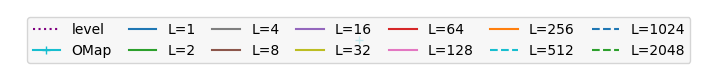

In [343]:
fig, ax = plt.subplots(1, figsize=(9, 0.8))  # min size
ax.plot([0], [0], label='level', ls=':', color='purple')
ax.plot([0], [0], label='OMap', marker='+')
for lf in expected_lfs:
    ax.plot([0, 0], [0, 0], label=f'L={lf}')
ax.set_axis_off()
fig.legend(
    loc='center',
    ncols=7,
    facecolor='whitesmoke',
    columnspacing=1.2,
)
plt.savefig('picouts/s-lf-legend.svg', format='svg', bbox_inches='tight')
plt.show()


OFS[SSD]: 128
s2


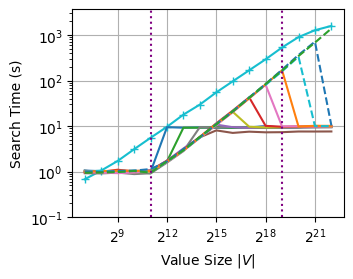

s3


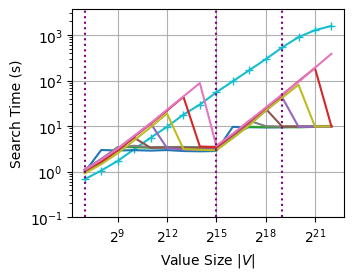

s24


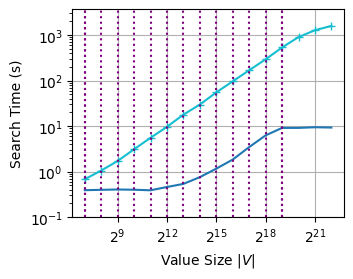

In [344]:
indiver('SSD', 128)


OFS[HDD]: 128
s2


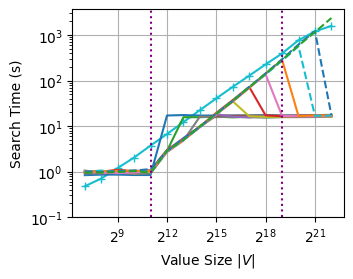

s3


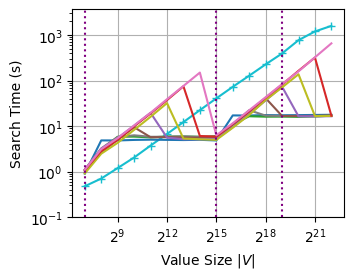

s24


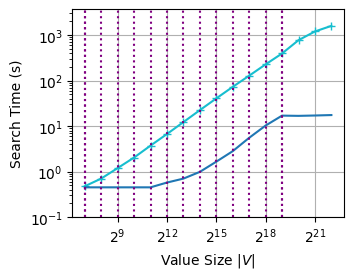

In [345]:
indiver('HDD', 128)


OFS[Mem]: 128
s2


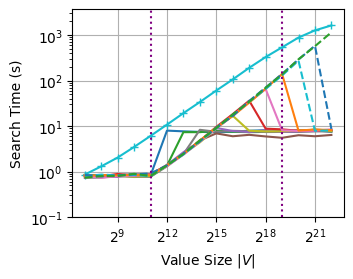

s3


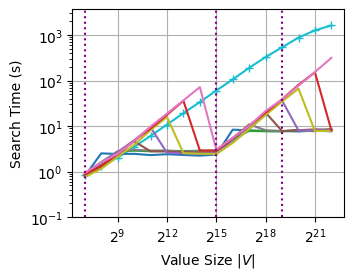

s24


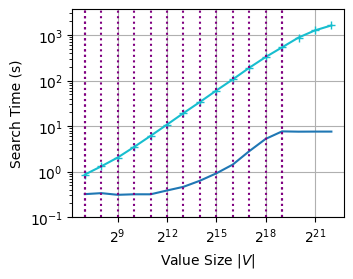

In [346]:
indiver('Mem', 128)


In [325]:
ratios = {}


def ssdofsetc(name, bbs, savefig1=None, mult=None):
    global ratios
    name_bbs = bbs
    g = gns[name]
    ds = filterrnz(filterr(g[1], 'bbs', bbs), 'id')
    om = filterrnz(filterr(g[3], 'bbs', bbs), 'id')
    if mult is not None:
        name_bbs = 4096

        ds = pd.merge(ds, mult, left_on='id', right_on='x')
        ds['search'] *= ds['mult']
        om = pd.merge(om, mult, left_on='id', right_on='x')
        om['search'] *= ds['mult'] * ds['id']

    print(f'OFS[{name}]: {name_bbs}')
    graph_by(ds, 's', 'lf', 'vl', 'search', sharey=False, omap=om)
    if savefig1 is not None:
        plt.savefig(savefig1, bbox_inches='tight')
    plt.show()

    ds = filterrnot(ds, 's', 4)
    # om['n'] = np.log2(om['id']).astype(np.int64)
    om['n'] = om['id']
    om.drop(columns='id', inplace=True)
    omd = pd.pivot_table(om, index='n', values='search')
    omd['s=1'] = omd['search']
    for s in sorted(list(set(ds['s']))):
        t = filterr(ds, 's', s)
        # t['vl'] = np.log2(t['vl']).astype(np.int64)
        ofd = pd.pivot_table(t, index='vl', columns='lf', values='search')
        ofd['om'] = omd['search']
        ofd['best'] = ofd.min(axis=1)
        omd[f'{s=}'] = ofd['best']
        ox = (omd['search'] / ofd['best'])[7:]
        print(f'{s=}: min={ox.min():.2f}, avg={ox.mean():.2f}, max={ox.max():.2f}')
        print(list(ox))
        print(list(omd['search']))
        print(list(ofd['best']))
#
    omd.drop(columns=['search'], inplace=True)
    ratios[name] = omd


OFS[SSD]: 128


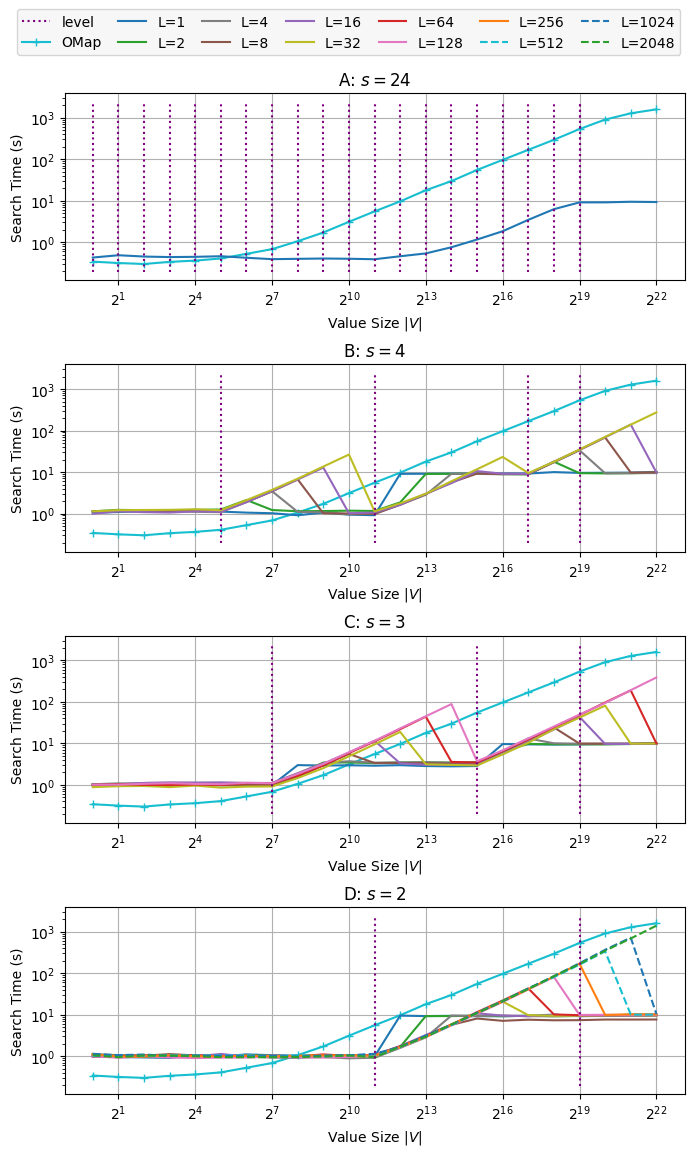

/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ox = (omd['search'] / ofd['best'])[7:]
/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ox = (omd['search'] / ofd['best'])[7:]
/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtyp

s=2: min=1.00, avg=42.66, max=208.74
[1.0, 1.1586811826694552, 1.8541576524342755, 3.518553957886694, 6.025936420405628, 6.120633757600458, 6.3189319001888995, 5.357977057838663, 6.850924018261663, 13.608864172398368, 22.323509966240387, 40.23558556800291, 72.6527967411864, 118.62469099176026, 168.16101020157214, 208.74272724351556]
[0.340737, 0.315005, 0.298803, 0.335912, 0.361049, 0.405536, 0.524989, 0.68101, 1.055978, 1.714102, 3.103537, 5.529339, 9.65653, 17.87641, 29.713653, 55.132537, 96.411032, 168.486245, 293.776708, 534.134498, 902.857624, 1277.975079, 1591.576667]
[0.340737, 0.315005, 0.298803, 0.335912, 0.361049, 0.405536, 0.524989, 0.68101, 0.911362, 0.924464, 0.882049, 0.91759, 1.577701, 2.829024, 5.545685, 8.04746, 7.084429, 7.54748, 7.301415, 7.351878, 7.611043, 7.599711, 7.624585]
s=3: min=1.00, avg=35.24, max=165.27
[1.0, 1.0, 1.0, 1.0494693708060614, 1.9122120575060184, 3.2465286474626796, 6.3143607792383944, 10.65322407741371, 19.453793456303313, 17.797828359587974, 

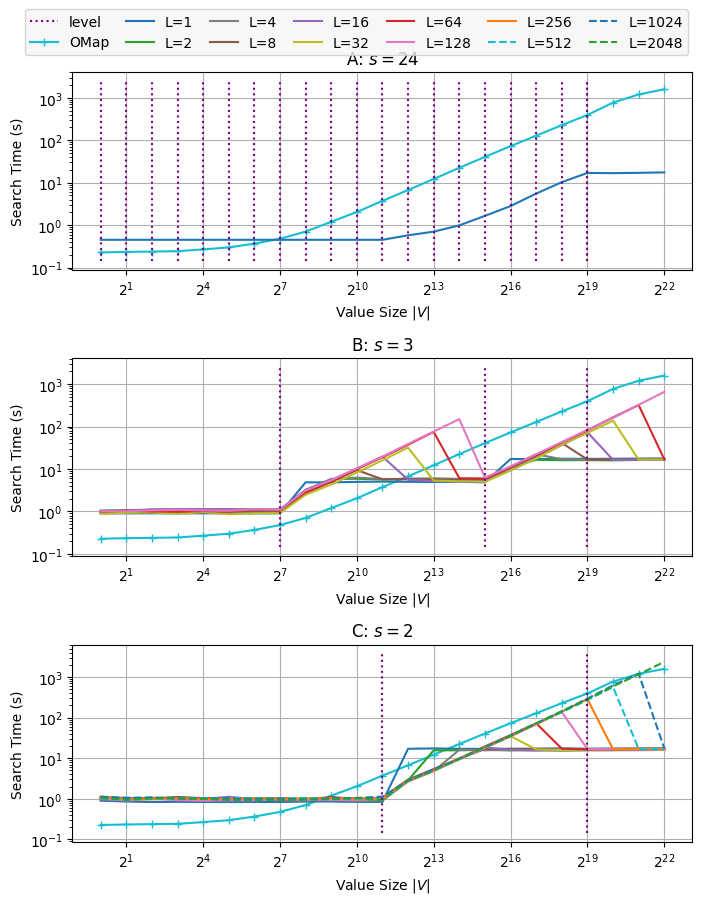

/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ox = (omd['search'] / ofd['best'])[7:]
/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ox = (omd['search'] / ofd['best'])[7:]
/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtyp

s=2: min=1.00, avg=18.57, max=99.31
[1.0, 1.0, 1.3936374509276437, 2.4242622935241473, 4.4299544107969675, 2.4988127736273893, 2.549057658795983, 2.3771291394597247, 2.586714051835042, 4.683018291217231, 8.221911293479678, 14.607751893331772, 25.059606397376125, 49.06455116048764, 75.87149826680823, 99.31332559799154]
[0.227312, 0.233718, 0.238445, 0.242947, 0.267966, 0.298394, 0.366394, 0.476752, 0.704007, 1.19669, 2.040904, 3.729428, 6.702045, 12.259287, 22.410776, 40.615315, 72.834215, 128.154882, 227.122311, 394.548903, 772.725653, 1200.755776, 1593.539325]
[0.227312, 0.233718, 0.238445, 0.242947, 0.267966, 0.298394, 0.366394, 0.476752, 0.704007, 0.858681, 0.841866, 0.841866, 2.6820917, 4.8093408, 9.4276645, 15.7015094, 15.552835899999998, 15.586994, 15.5480674, 15.7444174, 15.749163800000002, 15.8261772, 16.0455741]
s=3: min=1.00, avg=18.41, max=96.79
[1.0, 1.0, 1.0, 1.0, 1.0, 1.345557101470225, 2.4822234321346763, 4.48158693477667, 8.401099053391814, 7.909095233949671, 7.79081154

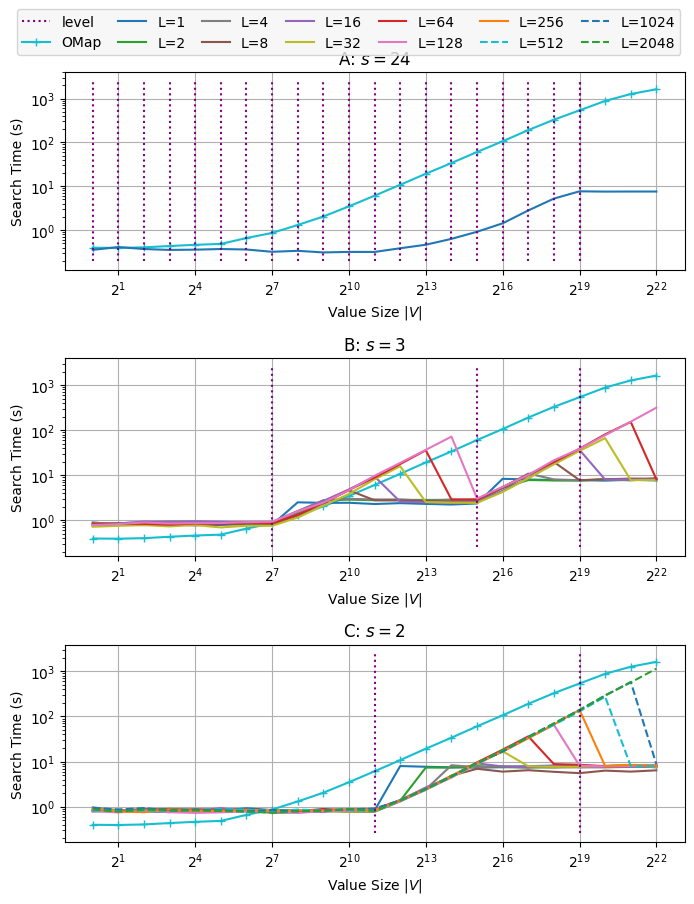

s=2: min=1.18, avg=53.62, max=254.90
[1.1831940246074748, 1.7835841597768367, 2.6688221836643784, 4.568386393956329, 7.893861022651366, 8.267311651619046, 8.176968718627727, 7.696482247255661, 8.747597948538651, 17.727394876207935, 29.664860716015312, 55.464477886754025, 97.17280200318696, 140.0086912017443, 211.96049458857482, 254.89936223893878]
[0.396243, 0.392315, 0.403172, 0.433311, 0.461393, 0.48362, 0.658348, 0.860918, 1.304599, 2.038177, 3.478888, 6.091001, 10.772848, 19.275172, 33.790227, 60.490186, 106.067971, 190.791949, 328.880182, 537.940659, 882.0723, 1268.357883, 1628.880637]
[0.396243, 0.392315, 0.403172, 0.433311, 0.461393, 0.48362, 0.658348, 0.7276219978254285, 0.7314479627152735, 0.763699062633509, 0.7615135192159614, 0.7716123937984118, 1.3030654285169323, 2.35725152721812, 4.3903469032295375, 6.9150624383811925, 5.983280213516008, 6.431580812951406, 5.929564191904939, 5.535917951427986, 6.300125316713271, 5.983935286912505, 6.390289181944332]
s=3: min=1.00, avg=44.

/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ox = (omd['search'] / ofd['best'])[7:]
/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ox = (omd['search'] / ofd['best'])[7:]
/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_21782/1126567977.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtyp

In [326]:
ratios = {}
bs = 128

ssdofsetc(
    'SSD',
    bs,
)
ssdofsetc(
    'HDD',
    bs,
)
ssdofsetc(
    'Mem',
    bs,
)


bs128-SSD


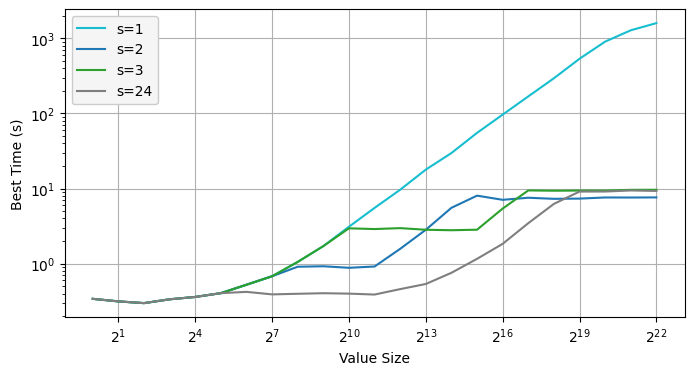

bs128-HDD


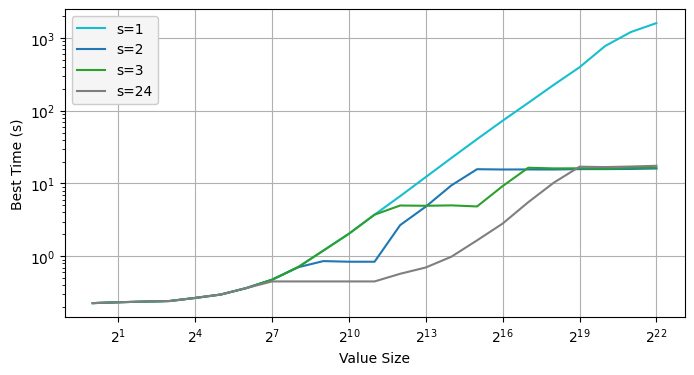

bs128-Mem


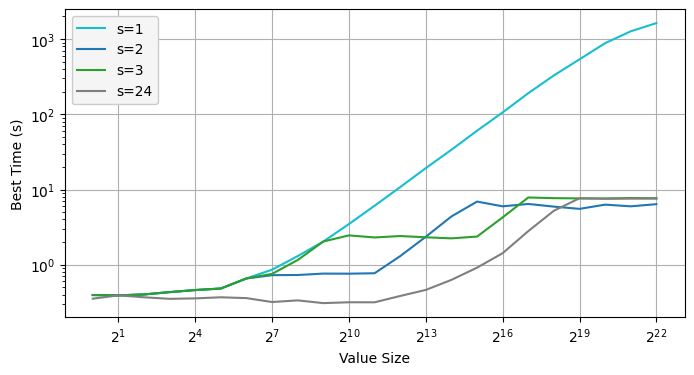

In [329]:
bs = 128
nplots = len(ratios)
# _, axs = plt.subplots(len(ratios),
#                       #   figsize=(13, 3*nplots + 1),
#                       figsize=(10, (3*nplots)+1),
#                       sharex=True, sharey=True)
# axs = axs if nplots > 1 else [axs]
# letters = ['C', 'B', 'A']
# for name, omd in zip(ratios, axs):
for name in ratios:
    omd = ratios[name]
    # for c in filter(lambda x: x!='search', omd.columns):
    #     omd[c] = omd[c].apply(lambda x: x if x > 1.0 else 1.)
    #     omd[c] = 1 / omd[c]
    #     omd[c] *= omd['search']
    # # print(omd.columns)
    fig, ax = plt.subplots(1, figsize=(8, 4))
    omd.plot(ax=ax,
             #  kind='bar', width=.65,
             legend=False, logy=True,
             rot=0, xlabel='Value Size',
             ylabel='Best Time (s)')
    # ax.set_title(f'{letters.pop()}: {name}')
    # _ = ax.hlines(y=1, xmin=-1, xmax=24, colors='b',
    #               linestyles=':', label='OMap (base)')
    # bars = ax.patches
    # hatches = np.repeat(hatch_patterns, len(omd))
    # colors = np.repeat(['tab:green', 'tab:blue', 'tab:orange'], len(omd))

    # for bar, hatch, color in zip(bars, hatches, colors):
    #     bar.set_facecolor(color)
    #     bar.set_hatch(hatch)
    ax.legend(
        facecolor='whitesmoke',
        framealpha=1,
    )
    ax.grid()
    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    plt.savefig(f'picouts/best-bs{bs}-{name}.svg',
                format='svg', bbox_inches='tight')
    print(f'bs{bs}-{name}')
    plt.show()

# p = '/Users/amin/Library/CloudStorage/Dropbox/Apps/Overleaf/IOObliviousMultiMap - USENIX/plots/speedups-var-media_s.png'
# plt.savefig(p, bbox_inches='tight')
# plt.show()


# _, ax = plt.subplots(3, figsize=(13, 3))

# omd.plot(ax=ax, kind='bar', legend=False, logy=True,
#          rot=40, xlabel='value size $|v|$', ylabel='best speedup')
# _ = ax.hlines(y=1, xmin=-1, xmax=24, colors='b',
#               linestyles=':', label='OMap (base)')
# ax.legend()
# ax.grid()
# if savefig3 is not None:
#     plt.savefig(savefig3)
# plt.show()


In [284]:
grower = np.asarray([
    [0] + list(map(lambda x: 1 << x, range(23))),
    [0, 1.40483256,  1.74515512,  2.42290352,  3.58424298,  5.59994821,
     8.66248206, 12.86392523, 17.72759683, 22.33759061, 25.85731617,
     28.40730517, 29.93514569, 30.82870977, 31.34132329, 31.63526666,
     31.79430846, 31.88201449, 31.93141434, 31.95871927, 28.51482316,
     28.5350356, 28.53521099, 28.5350383],
])

grower = pd.DataFrame({'x': grower[0], 'mult': grower[1]})


OFS[SSD]: 4096


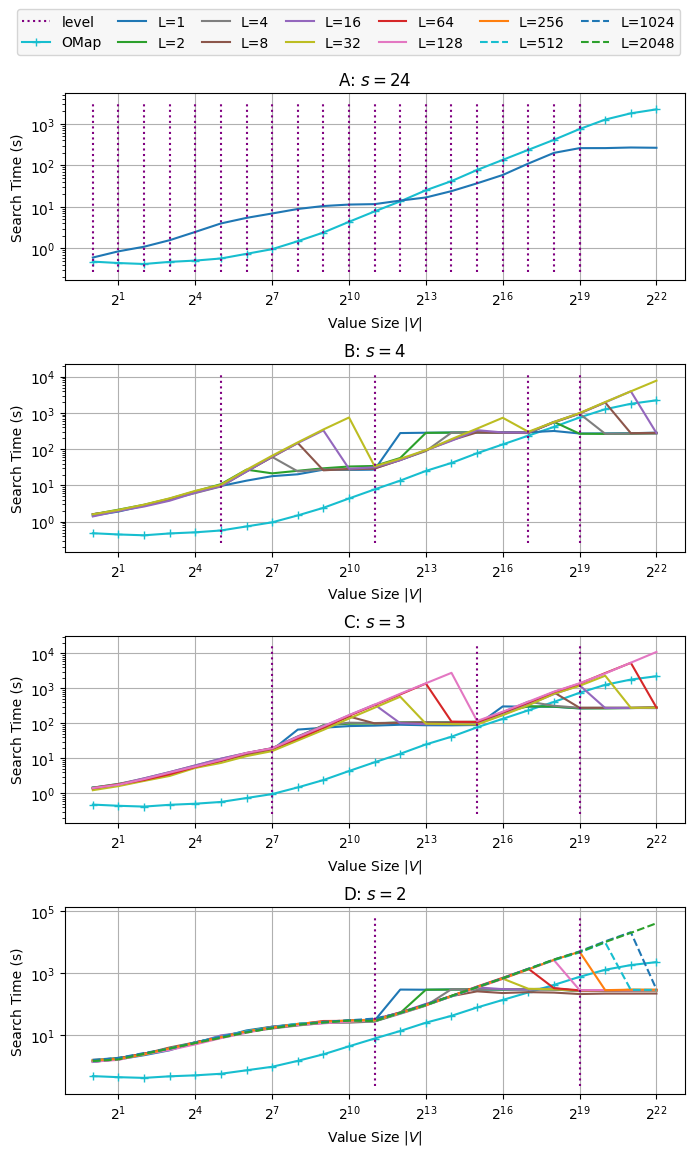

s=2: min=0.42, avg=71.53, max=236.69
s=3: min=0.42, avg=84.13, max=299.11
s=24: min=0.42, avg=66.79, max=269.33
OFS[HDD]: 4096


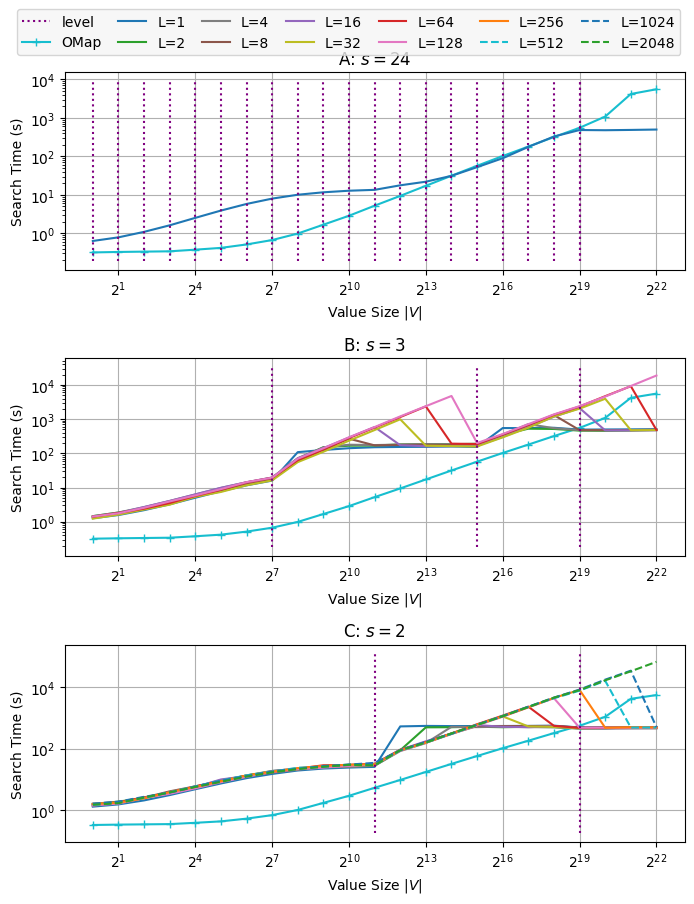

s=2: min=0.32, avg=110.37, max=457.86
s=3: min=0.32, avg=112.31, max=469.78
s=24: min=0.32, avg=115.67, max=498.93
OFS[Mem]: 4096


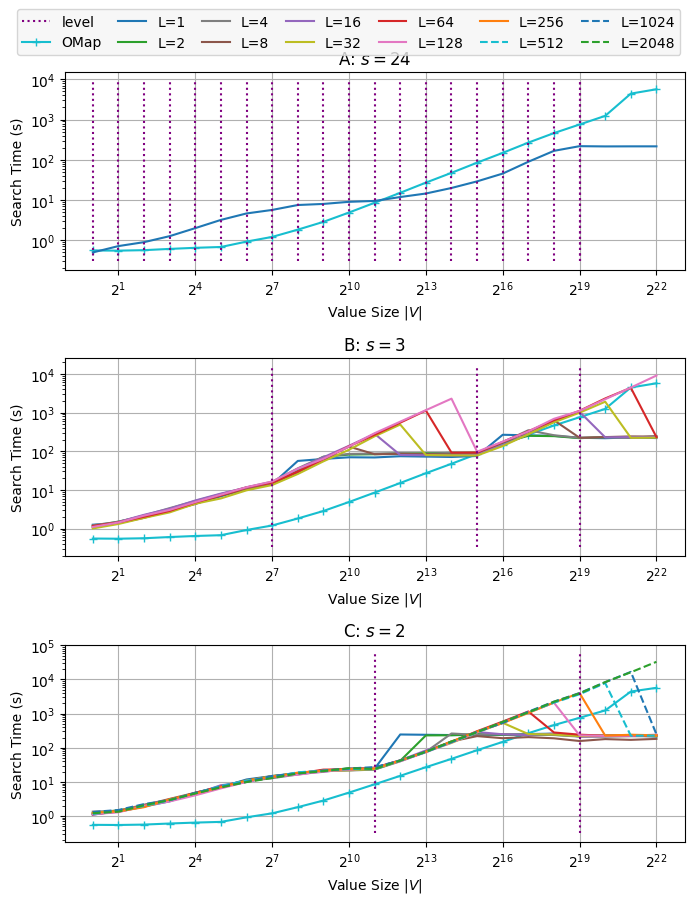

s=2: min=0.55, avg=62.31, max=205.37
s=3: min=0.55, avg=73.67, max=250.37
s=24: min=0.50, avg=55.11, max=218.39


In [285]:
ratios = {}
bs = 128

ssdofsetc(
    'SSD',
    bs,
    mult=grower,
)
ssdofsetc(
    'HDD',
    bs,
    mult=grower,
)
ssdofsetc(
    'Mem',
    bs,
    mult=grower,
)


bs4096-SSD


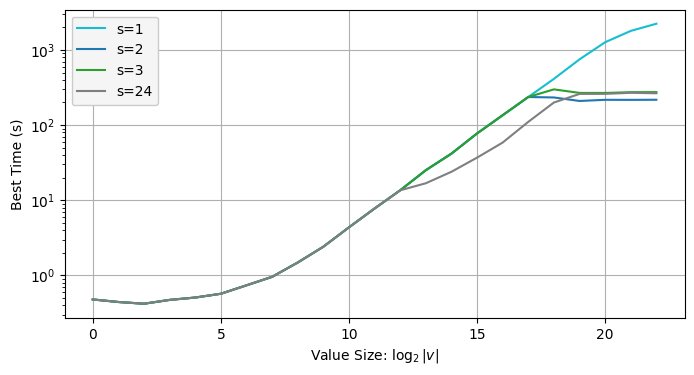

bs4096-HDD


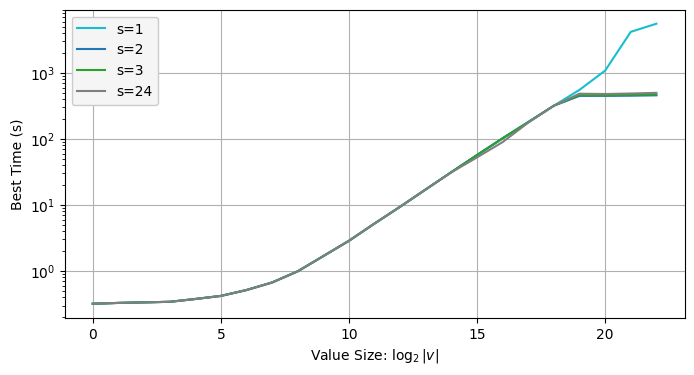

bs4096-Mem


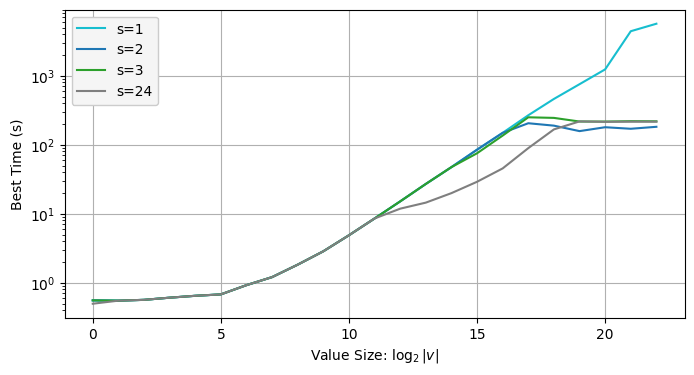

In [293]:
bs = 4096
nplots = len(ratios)
# _, axs = plt.subplots(len(ratios),
#                       #   figsize=(13, 3*nplots + 1),
#                       figsize=(10, (3*nplots)+1),
#                       sharex=True, sharey=True)
# axs = axs if nplots > 1 else [axs]
# letters = ['C', 'B', 'A']
# for name, omd in zip(ratios, axs):
for name in ratios:
    omd = ratios[name]
    # for c in filter(lambda x: x!='search', omd.columns):
    #     omd[c] = omd[c].apply(lambda x: x if x > 1.0 else 1.)
    #     omd[c] = 1 / omd[c]
    #     omd[c] *= omd['search']
    # # print(omd.columns)
    fig, ax = plt.subplots(1, figsize=(8, 4))
    omd.plot(ax=ax,
             #  kind='bar', width=.65,
             legend=False, logy=True,
             rot=0, xlabel='Value Size: $\log_2 |v|$',
             ylabel='Best Time (s)')
    # ax.set_title(f'{letters.pop()}: {name}')
    # _ = ax.hlines(y=1, xmin=-1, xmax=24, colors='b',
    #               linestyles=':', label='OMap (base)')
    # bars = ax.patches
    # hatches = np.repeat(hatch_patterns, len(omd))
    # colors = np.repeat(['tab:green', 'tab:blue', 'tab:orange'], len(omd))

    # for bar, hatch, color in zip(bars, hatches, colors):
    #     bar.set_facecolor(color)
    #     bar.set_hatch(hatch)
    ax.legend(
        facecolor='whitesmoke',
        framealpha=1,
    )
    ax.grid()
    plt.savefig(f'picouts/best-bs{bs}-{name}.svg',
                format='svg', bbox_inches='tight')
    print(f'bs{bs}-{name}')
    plt.show()

# p = '/Users/amin/Library/CloudStorage/Dropbox/Apps/Overleaf/IOObliviousMultiMap - USENIX/plots/speedups-var-media_s.png'
# plt.savefig(p, bbox_inches='tight')
# plt.show()


# _, ax = plt.subplots(3, figsize=(13, 3))

# omd.plot(ax=ax, kind='bar', legend=False, logy=True,
#          rot=40, xlabel='value size $|v|$', ylabel='best speedup')
# _ = ax.hlines(y=1, xmin=-1, xmax=24, colors='b',
#               linestyles=':', label='OMap (base)')
# ax.legend()
# ax.grid()
# if savefig3 is not None:
#     plt.savefig(savefig3)
# plt.show()


In [198]:
ratios = {}
bs = 4096

try:
    ssdofsetc(
        'SSD',
        bs,
    )
except Exception as e:
    print(e)
try:
    ssdofsetc(
        'HDD',
        bs,
    )
except Exception as e:
    print(e)
try:
    ssdofsetc(
        'Mem',
        bs,
    )
except Exception as e:
    print(e)


OFS[SSD]: 4096
Number of rows must be a positive integer, not 0
OFS[HDD]: 4096
Number of rows must be a positive integer, not 0
OFS[Mem]: 4096
Number of rows must be a positive integer, not 0


<Figure size 800x100 with 0 Axes>

<Figure size 800x100 with 0 Axes>

<Figure size 800x100 with 0 Axes>

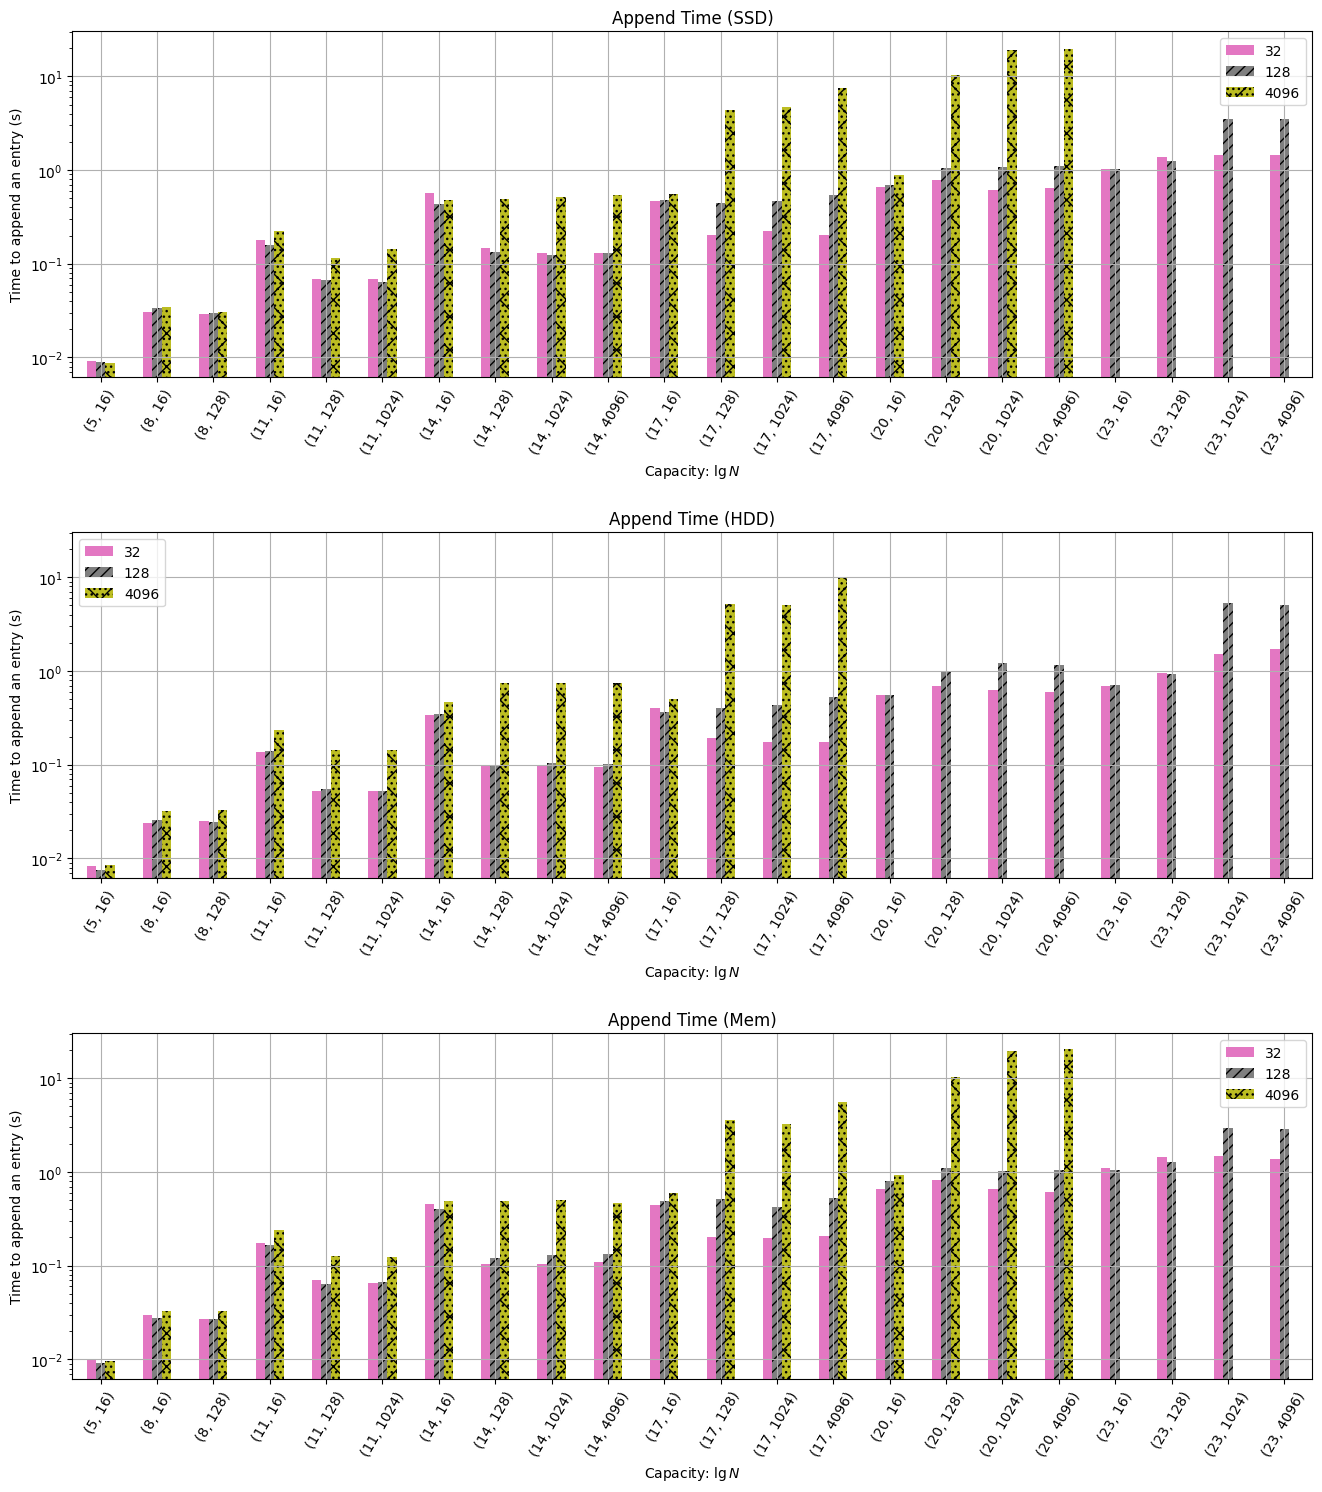

In [12]:
vls = sorted(list(set([x for xapp in app for x in set(xapp['bbs'])])))
# nplots = sum([len(set(x['bbs'])) for x in app])
nplots = len(names)
fig, axs = plt.subplots(
    nplots,
    sharex=False, sharey=True,
    figsize=(16, (5.5*nplots)+1)
)

# ax_idx = 0
for idx, iapp in enumerate(app):
    # ax = axs[ax_idx]
    # ax_idx += 1
    ax = axs[idx]

    ds = filterrnz((
        # filterr(iapp, 'bbs', vl)
        # ['vl', 'n', 'append']]
        iapp[['bbs', 'vl', 'n', 'append']]
        .sort_values(by=['n', 'bbs', 'vl'])
    ), 'vl')
    ds['n'] = np.log2(ds['n']).astype(np.int32)
    ds['vl'] = ds['vl'].astype(np.int32)
    # ds = filterrgte(ds, 'n', 14)
    ds = (
        ds
        # .pivot_table(index='n', columns='Block Size', values='append')
        # .pivot_table(index=['n'], columns=['bbs', 'vl'], values='append')
        .pivot_table(index=['n', 'vl'], columns=['bbs'], values='append')
        # .pivot_table(index='n', columns=['vl', 'bbs'], values='append')
        # .drop(columns=0.0)
        # .add_prefix('$|v|=')
        # .add_suffix('$')
    )

    ds.plot(ax=ax, kind='bar', bottom=0, legend=False, logy=True, rot=60)

    bars = ax.patches
    # hatches = ''.join(h*len(ds) for h in 'x+O-')
    hatches = np.repeat(hatch_patterns, len(ds))
    colors = np.repeat(color3.by_key()['color'][6:9], len(ds))
    for bar, hatch, color in zip(bars, hatches, colors):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
    ax.legend()
    ax.set_xlabel('Capacity: $\lg N$')
    ax.set_ylabel('Time to append an entry (s)')
    ax.set_title(f'Append Time ({names[idx]})')
    ax.grid()
    # ax.set_xscale('log', base=2)
    # ax.set_yscale('log')

plt.subplots_adjust(hspace=.45)
plt.legend()
plt.show()


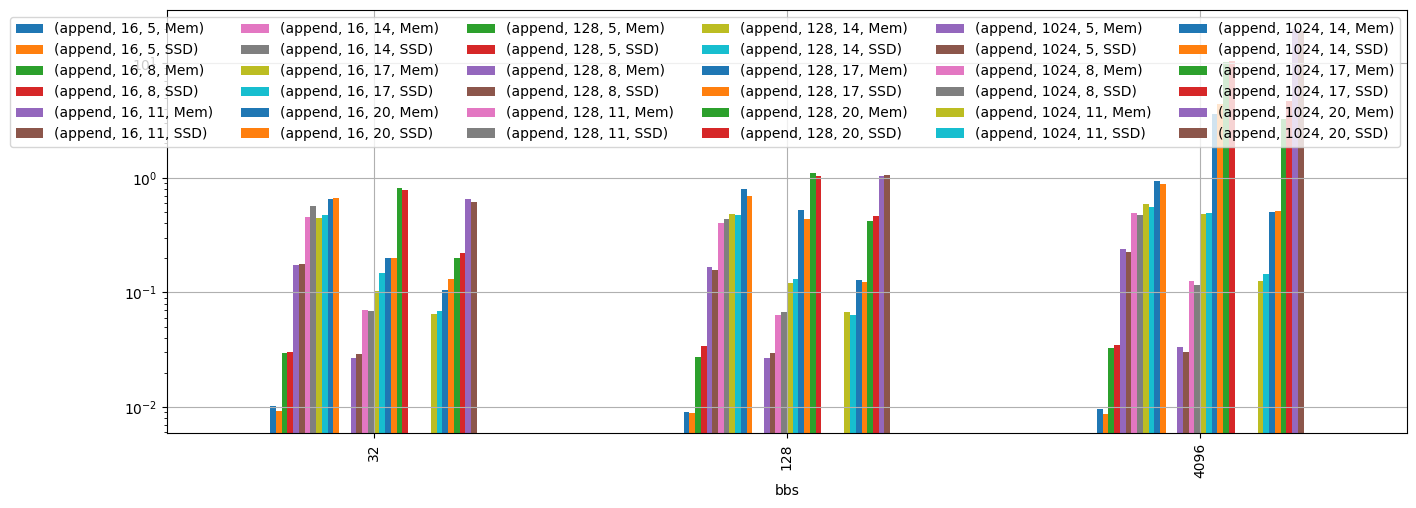

In [13]:
app_blocked = {}
for name, _, iapp, _ in [ss, mm]:
    ds = filterrnz((
        iapp[['bbs', 'vl', 'n', 'append']]
        .sort_values(by=['n', 'bbs', 'vl'])
    ), 'vl')
    ds['n'] = np.log2(ds['n']).astype(np.int32)
    ds['vl'] = ds['vl'].astype(np.int32)
    ds = filterrnot(ds, 'n', 23)
    ds = filterrnot(ds, 'vl', 4096)
    ds['media'] = name
    ds = ds.pivot_table(
        # index=['media', 'n', 'vl'],
        index=['bbs', 'media', 'n', 'vl'],
        # columns=['bbs'],
        values='append'
    )
    app_blocked[name] = ds

x = pd.concat(app_blocked.values())

fig, ax = plt.subplots(figsize=(16, 5.5))
x.unstack().unstack().unstack().plot(kind='bar', ax=ax, legend=False)
ax.set_yscale('log')
ax.legend(ncol=6)
ax.grid()
plt.show()


/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_2066/4172163422.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append({


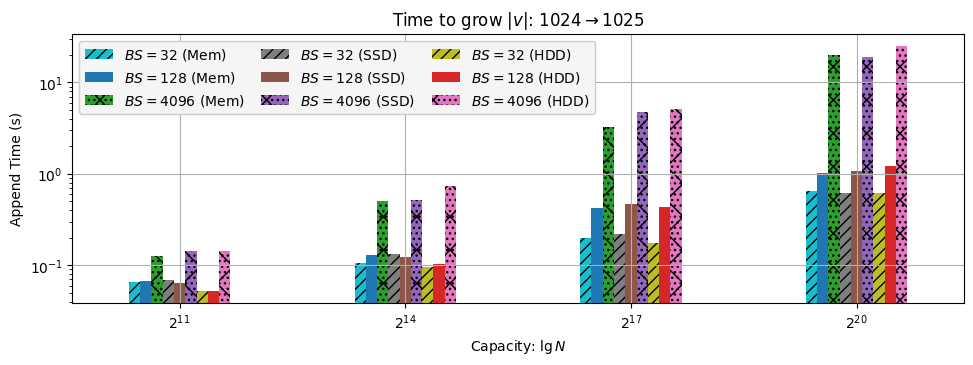

In [42]:
def perm(l):
    return l[3:6] + l[6:9] + l[:3]


app_blocked = {}
for name, _, iapp, _ in [ss, mm, hh]:
    ds = filterrnz((
        iapp[['bbs', 'vl', 'n', 'append']]
        .sort_values(by=['n', 'bbs', 'vl'])
    ), 'vl')
    if name == 'HDD':
        ds = ds.append({
            'bbs': 4096,
            'vl': 1024,
            'n': 1048576,
            'append': 25.13,
        }, ignore_index=True)
    # ds['n'] = np.log2(ds['n']).astype(np.int32)
    ds['n'] = ds['n'].astype(np.int32)
    ds['vl'] = ds['vl'].astype(np.int32)
    # ds = filterrnot(ds, 'n', 23)
    # ds = filterrnot(ds, 'n', 5)
    # ds = filterrnot(ds, 'n', 8)
    ds = filterrnot(ds, 'n', 1 << 23)
    ds = filterrnot(ds, 'n', 1 << 5)
    ds = filterrnot(ds, 'n', 1 << 8)
    ds = filterr(ds, 'vl', 1024)
    ds['media'] = name
    ds.drop(columns='vl')
    ds = ds.pivot_table(
        # index=['media', 'n', 'vl'],
        # index=['bbs', 'media', 'n', 'vl'],
        # columns=['bbs'],
        index=['n'],
        columns=['media', 'bbs'],
        values='append'
    )
    app_blocked[name] = ds

x = (
    pd.concat(app_blocked.values(), axis=1)
    # .reset_index('n', drop=True)
    .sort_values(axis=1, by=['media', 'bbs'])
)

x = x[perm(x.columns.tolist())]

fig, ax = plt.subplots(figsize=(11.5, 3.5))
x.plot(kind='bar', ax=ax, legend=False, rot=0, width=.45)
ax.set_yscale('log')
bars = ax.patches
# hatches = np.repeat(hatch_patterns, len(x))

# x.columns.size
hatches = 3 * np.repeat(hatch_patterns[
    :len(hatch_patterns) // (x.columns.size//3)],
    len(x)).tolist()
# colors = np.repeat(color3.by_key()['color'][:3], 3 * len(x)).tolist()
# for bar, hatch, color in zip(bars, hatches, colors):
for bar, hatch in zip(bars, hatches):
    # bar.set_facecolor(color)
    bar.set_hatch(hatch)
ax.grid()
ax.set_title('Time to grow $|v|$: $1024 \\rightarrow 1025$')
# ax.set_title('Time to grow $|v|$ from 1024 to 1025')
# ax.set_title('$|v|: 1024 \\rightarrow 1025$')
ax.set_xlabel('Capacity: $\lg N$')
ax.set_ylabel('Append Time (s)')
leg = ax.legend(
    [
        '$BS = 32$ (Mem)',
        '$BS = 128$ (Mem)',
        '$BS = 4096$ (Mem)',
        '$BS = 32$ (SSD)',
        '$BS = 128$ (SSD)',
        '$BS = 4096$ (SSD)',
        '$BS = 32$ (HDD)',
        '$BS = 128$ (HDD)',
        '$BS = 4096$ (HDD)',
    ],
    ncols=3,
    columnspacing=1.2,
    framealpha=1,
    facecolor='whitesmoke',
)
# leg.get_frame().set_alpha(0.1)
# ax.set_xscale('log', base=2)
# ax.set_xticks(
#     # ticks=[
#     #     1 << 11,
#     #     1 << 14,
#     #     1 << 17,
#     #     1 << 20,
#     # ],
#     ticks=[
#         11,
#         14,
#         17,
#         20,
#     ],
#     labels=[
#         '$2^{11}$',
#         '$2^{14}$',
#         '$2^{17}$',
#         '$2^{20}$',
#     ],
# )
ax.set_xticklabels(
    [
        '$2^{11}$',
        '$2^{14}$',
        '$2^{17}$',
        '$2^{20}$',
    ],
)

plt.savefig(
    'picouts/append-1024.svg',
    bbox_inches='tight',
    format='svg',
)
plt.show()


/var/folders/08/x9549q_j74x4hj2mlqb3dtgw0000gn/T/ipykernel_2066/3110373175.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append({


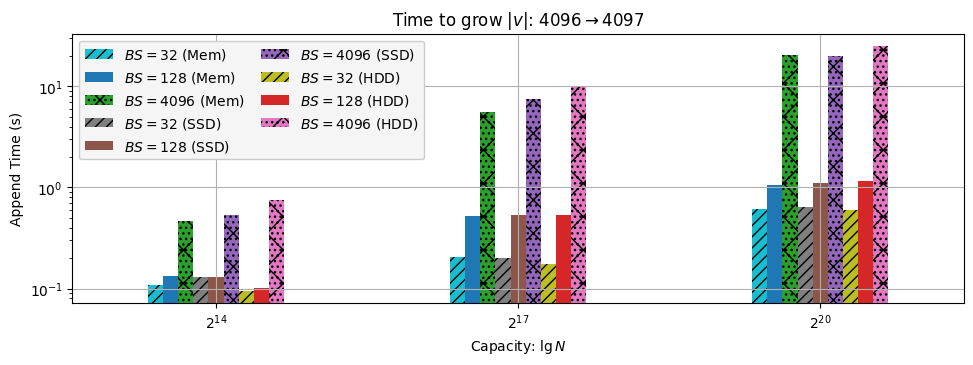

In [43]:
def perm(l):
    return l[3:6] + l[6:9] + l[:3]


app_blocked = {}
for name, _, iapp, _ in [ss, mm, hh]:
    ds = filterrnz((
        iapp[['bbs', 'vl', 'n', 'append']]
        .sort_values(by=['n', 'bbs', 'vl'])
    ), 'vl')
    if name == 'HDD':
        ds = ds.append({
            'bbs': 4096,
            'vl': 4096,
            'n': 1048576,
            'append': 25.13,
        }, ignore_index=True)
    # ds['n'] = np.log2(ds['n']).astype(np.int32)
    ds['n'] = ds['n'].astype(np.int32)
    ds['vl'] = ds['vl'].astype(np.int32)
    # ds = filterrnot(ds, 'n', 23)
    ds = filterrnot(ds, 'n', 1<<23)
    # ds = filterrnot(ds, 'n', 5)
    # ds = filterrnot(ds, 'n', 8)
    ds = filterr(ds, 'vl', 4096)
    ds['media'] = name
    ds.drop(columns='vl')
    ds = ds.pivot_table(
        # index=['media', 'n', 'vl'],
        # index=['bbs', 'media', 'n', 'vl'],
        # columns=['bbs'],
        index=['n'],
        columns=['media', 'bbs'],
        values='append'
    )
    app_blocked[name] = ds

x = (
    pd.concat(app_blocked.values(), axis=1)
    # .reset_index('n', drop=True)
    .sort_values(axis=1, by=['media', 'bbs'])
)

x = x[perm(x.columns.tolist())]

fig, ax = plt.subplots(figsize=(11.5, 3.5))
x.plot(kind='bar', ax=ax, legend=False, rot=0, width=.45)
ax.set_yscale('log')
bars = ax.patches
# hatches = np.repeat(hatch_patterns, len(x))

# x.columns.size
hatches = 3 * np.repeat(hatch_patterns[
    :len(hatch_patterns) // (x.columns.size//3)],
    len(x)).tolist()
# colors = np.repeat(color3.by_key()['color'][:3], 3 * len(x)).tolist()
# for bar, hatch, color in zip(bars, hatches, colors):
for bar, hatch in zip(bars, hatches):
    # bar.set_facecolor(color)
    bar.set_hatch(hatch)
ax.grid()
ax.set_title('Time to grow $|v|$: $4096 \\rightarrow 4097$')
# ax.set_title('Time to grow $|v|$ from 1024 to 1025')
# ax.set_title('$|v|: 1024 \\rightarrow 1025$')
ax.set_xlabel('Capacity: $\lg N$')
ax.set_ylabel('Append Time (s)')
leg = ax.legend(
    [
        '$BS = 32$ (Mem)',
        '$BS = 128$ (Mem)',
        '$BS = 4096$ (Mem)',
        '$BS = 32$ (SSD)',
        '$BS = 128$ (SSD)',
        '$BS = 4096$ (SSD)',
        '$BS = 32$ (HDD)',
        '$BS = 128$ (HDD)',
        '$BS = 4096$ (HDD)',
    ],
    ncols=2,
    columnspacing=1.2,
    framealpha=1,
    facecolor='whitesmoke',
)
# leg.get_frame().set_alpha(0.1)

ax.set_xticklabels(
    [
        '$2^{14}$',
        '$2^{17}$',
        '$2^{20}$',
    ],
)


plt.savefig(
    'picouts/append-4096.svg',
    bbox_inches='tight',
    format='svg',
)
plt.show()


In [381]:
x


media       Mem                            SSD                            HDD  \
bbs      32.0      128.0      4096.0    32.0      128.0      4096.0    32.0     
n                                                                               
14     0.109091  0.132015   0.465654  0.131415  0.129053   0.534795  0.094769   
17     0.206293  0.521811   5.535293  0.201481  0.534918   7.485254  0.175656   
20     0.612134  1.059774  20.467588  0.640459  1.108387  19.731129  0.598157   

media                       
bbs      128.0      4096.0  
n                           
14     0.100574   0.748663  
17     0.529627   9.928112  
20     1.163147  25.130000

In [82]:
tx = [11, 14, 17]
ty = [0.143299, 0.736783, 5.065710]

px = 20

data = np.asarray([tx, ty])
fit = np.polyfit(data[0, :], data[1, :], 2)

print(fit)

line = np.poly1d(fit)
line(px)


[ 0.20752461 -4.99028728 29.92598111]


13.130079999999978